In [41]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

character(0)

<a id="2"></a> <br>
### 1. Importación de librerías requeridas

In [42]:
library(Rssa)

<a id="9"></a> <br>
#### Ejercicio 3: Datos financieros

Continuemos ahora con un ejemplo de aplicación de SSA empleando datos financieros. Usaremos los datos des la serie de precios de cierre del activo META en fechas particulares que genran resultados útiles a la metodología SSA.

In [43]:
#Importación de librerias requeridas:
library(Rssa)
library(TTR)
library(quantmod)
library(xts)
library(tseries)
#library(TSA)
library(ggplot2)
library(PerformanceAnalytics) ##vamos a ver, rendimientos
library(Metrics)
library(tseries)

In [44]:
options(digits=3)
options(warn=-1)

#Obtención DATOS:
META<-getSymbols("META", from="2016-05-01", to="2018-01-28",auto.assign = FALSE)
META<-na.omit(META)
META<-META[,4]
head(META)
colnames(META)<-c("META")

           META.Close
2016-05-02        119
2016-05-03        117
2016-05-04        118
2016-05-05        118
2016-05-06        119
2016-05-09        119

An xts object on 2016-05-02 / 2018-01-26 containing: 
  Data:    double [439, 1]
  Columns: META
  Index:   Date [439] (TZ: "UTC")
  xts Attributes:
    $ src    : chr "yahoo"
    $ updated: POSIXct[1:1], format: "2023-05-14 22:16:37"


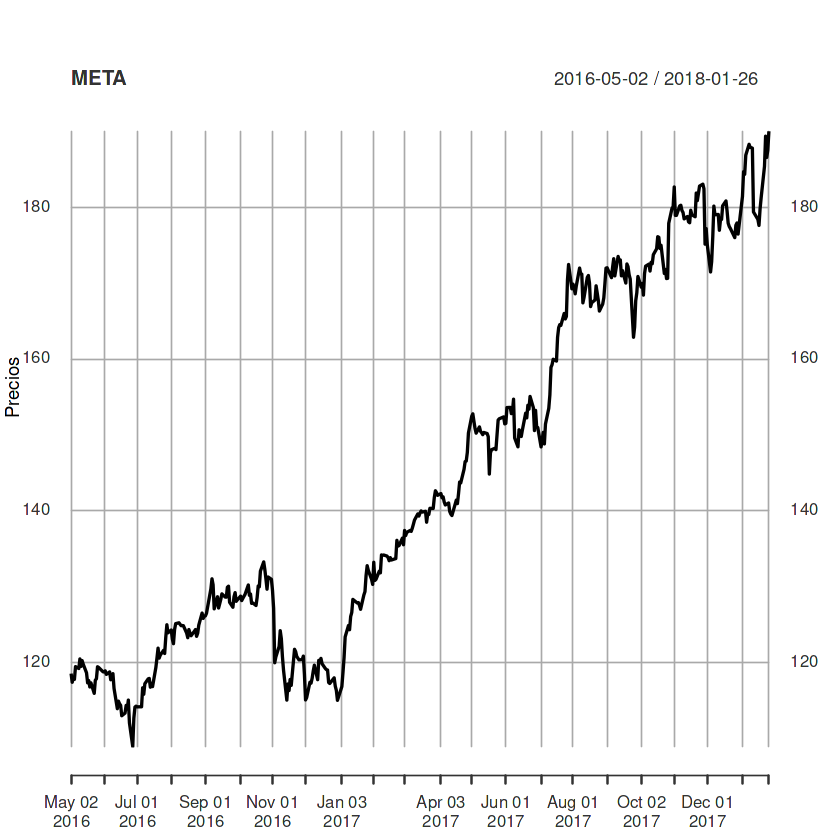

In [45]:
### Graficamos la serie
plot(META, ylab="Precios")
str(META)

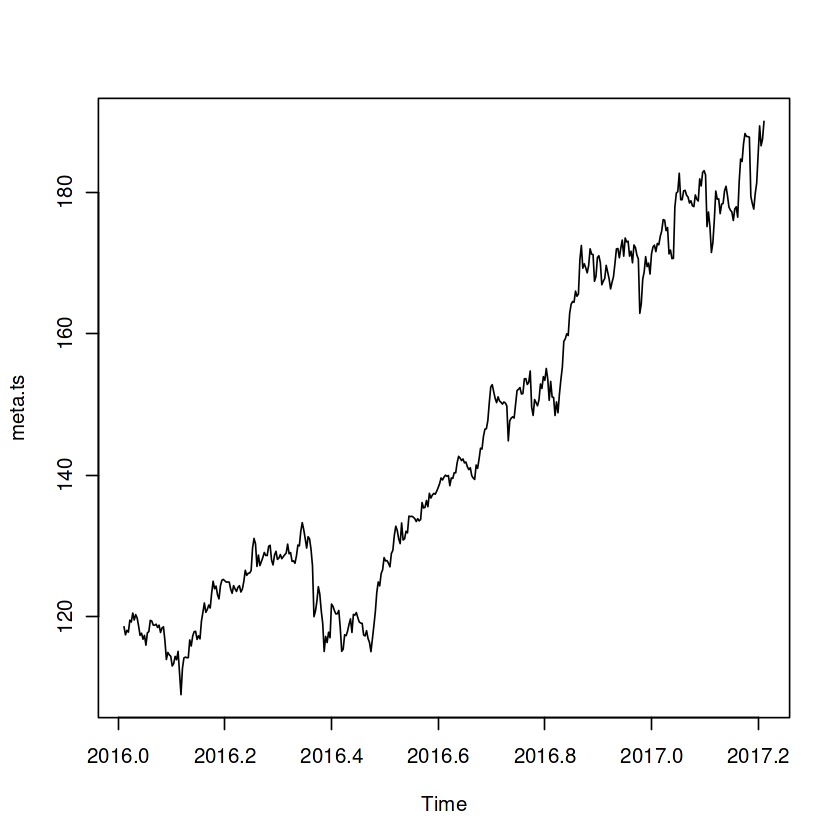

In [46]:
# Un paso importante que hay que hacer, es pasar los datos de formato xts a ts, que es el formato que emplea SSA. para ello, pasamos primero a data frame
# y luego a ts.
    META <- data.frame(date=index(META), coredata(META))
    META1<-META$META
    ##pasamos a ts
    meta.ts<-ts(META1, start=c(2016,05), frequency = 365)
    plot(meta.ts)

In [47]:
## Preprocesamiento: Partición de datos en conjunto de prueba y de entrenamiento.
## Podemos partir la serie en a manera de obtener 36 datos para la prueba. 
h <- round(length(meta.ts)*0.05, digits = 0)
h

[1] 22

In [48]:
#Una vez creada la ventana h, generamos los conjuntos de entrenamiento y prueba.
train<-meta.ts[1:(length(meta.ts)-h)]
test<-meta.ts[(length(meta.ts)-h+1):length(meta.ts)]
tail(train)
head(test)
str(test)

train.ts=ts(train,start=c(2019,08), frequency = 365)

[1] 180 181 180 178 177 177

[1] 176 178 178 176 181 185

 num [1:22] 176 178 178 176 181 ...


#### Pasos 1 y 2
En estos pasos, aplicamos la función de ssa() a la serie en formato ts y procedemos a la selección para la recosntrucción.

In [49]:
##SSA embeding y separación:
s1<-ssa(train.ts)  #Hay otros métodos como el "topelitz", para series estacionarias. En este caso no aplica.
s1


Call:
ssa(x = train.ts)

Series length: 417,	Window length: 209,	SVD method: eigen
Special triples:  0

Computed:
Eigenvalues: 50,	Eigenvectors: 50,	Factor vectors: 0

Precached: 0 elementary series (0 MiB)

Overall memory consumption (estimate): 0.0864 MiB

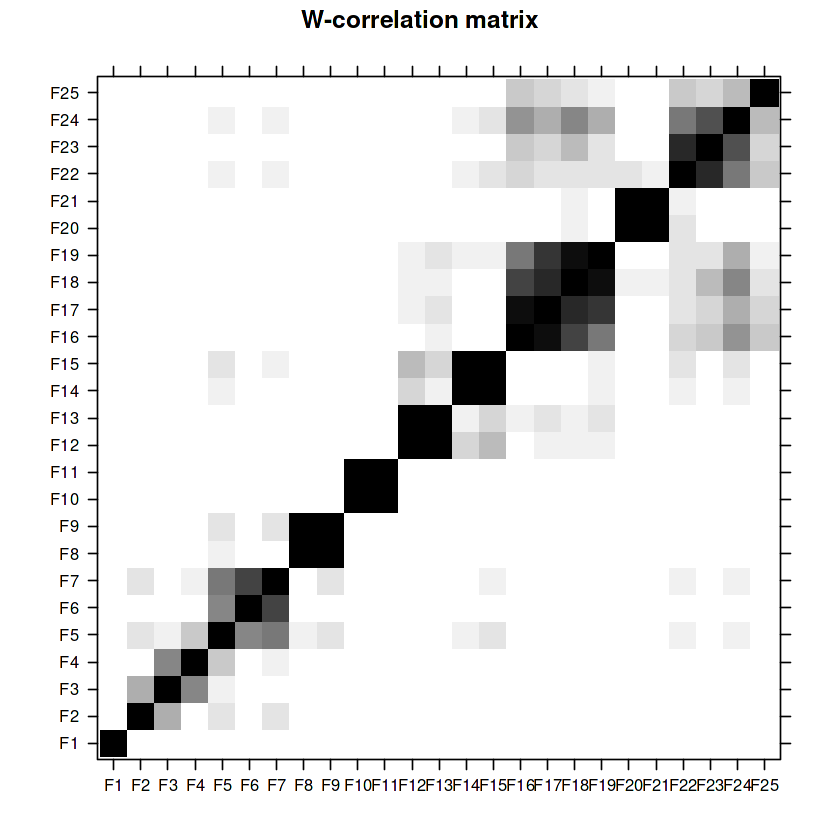

In [50]:
##Reconstrucción: empleamos las herramientas visuales para la selección.
wplot<-wcor(s1, group=1:25)
plot(wplot)

In [51]:
##Singular Values graph
Sing.plt<-function(Y,L){
  lambda<-log(SVD(Y,L)$d)
  d<-length(lambda)
  win<-1:d
  plot.new()
  plot.window(xlim=range(win), ylim=range(lambda))
  usr=par("usr")
  rect(usr[1], usr[3], usr[2], usr[4])
  lines(win, lambda, lwd=2)
  points(win, lambda, pch=21, bg="gray")
  axis(1)
  axis(2)
  box()
  title(xlab="Number")
  title(ylab="Log.Singular Values")}

##Función SVD
SVD<- function(Y,L){
  X<-UniHankel(Y,L)
  svd(X)
}

##Hankelización:
UniHankel=function(Y,L){
  k<-length(Y)-L+1
  outer((1:L), (1:k), function(x,y) Y[(x+y-1)])
}

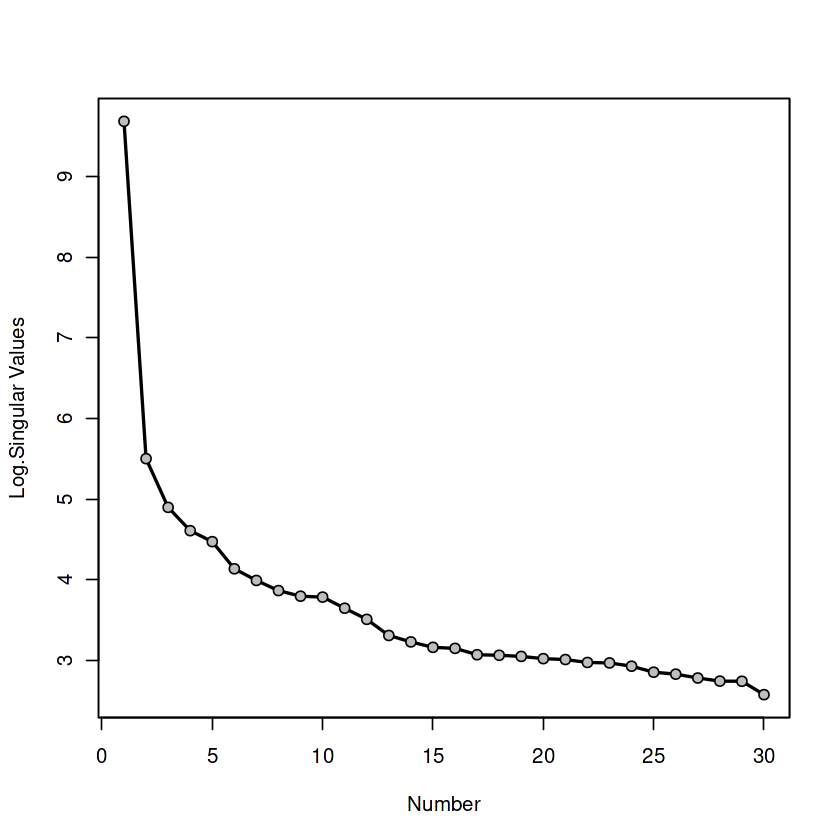

In [52]:
#Tambien generamos la scree-plot.
Sing.plt(meta.ts, 30)

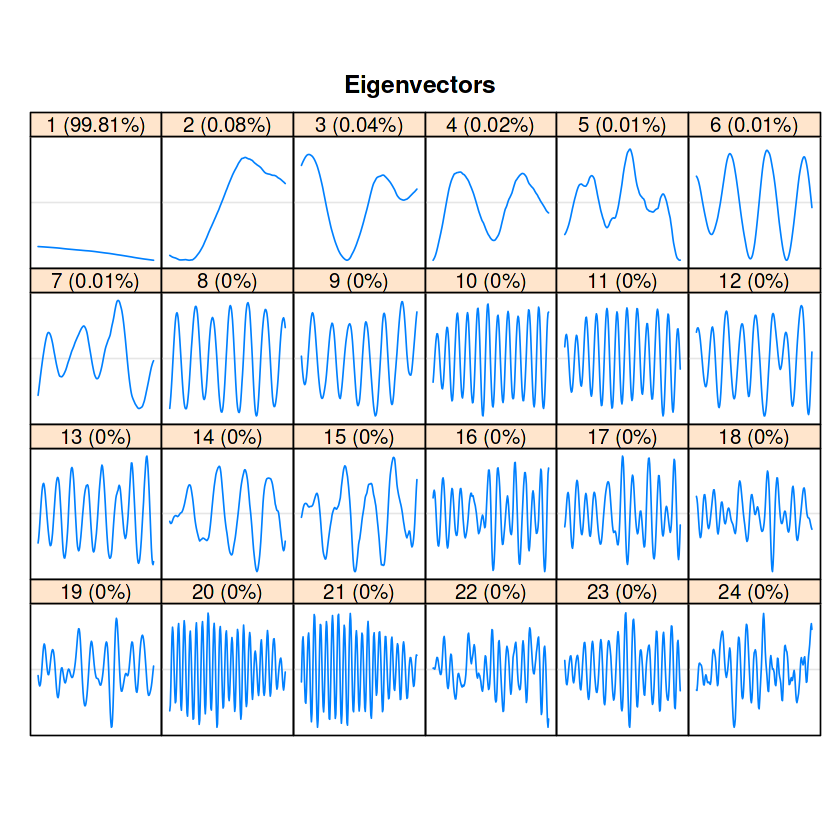

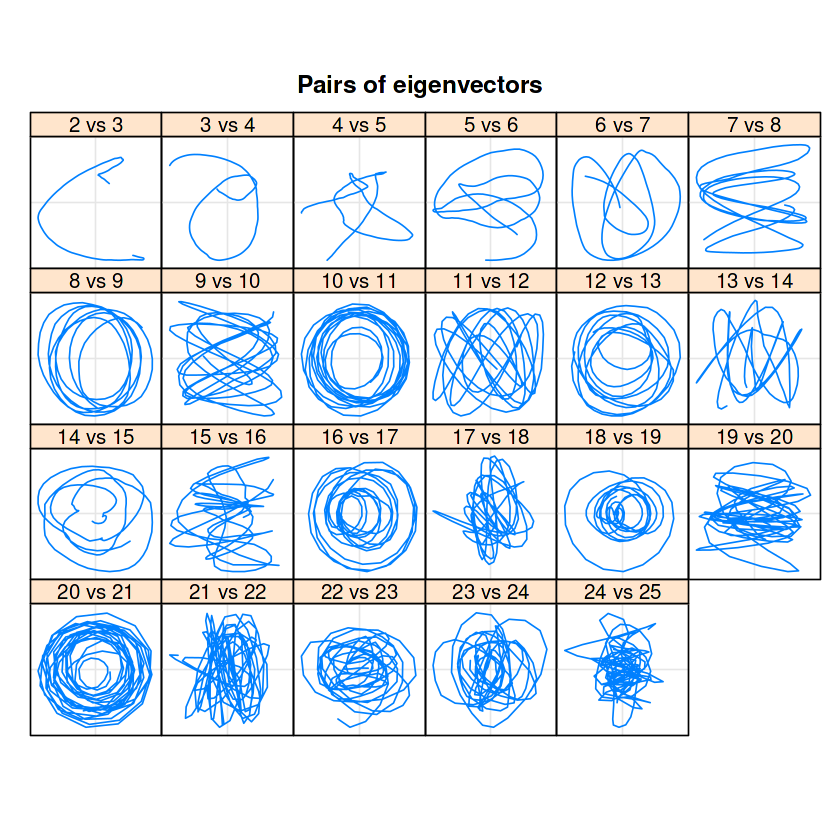

In [53]:
###Gráficas componentes 1D (compoente por componente) y la 2D (pares formen poligonos regulares : estables)
plot(s1, type="vectors", idx=1:24)
plot(s1, type= "paired", idx=2:24, plot.contrib = FALSE)

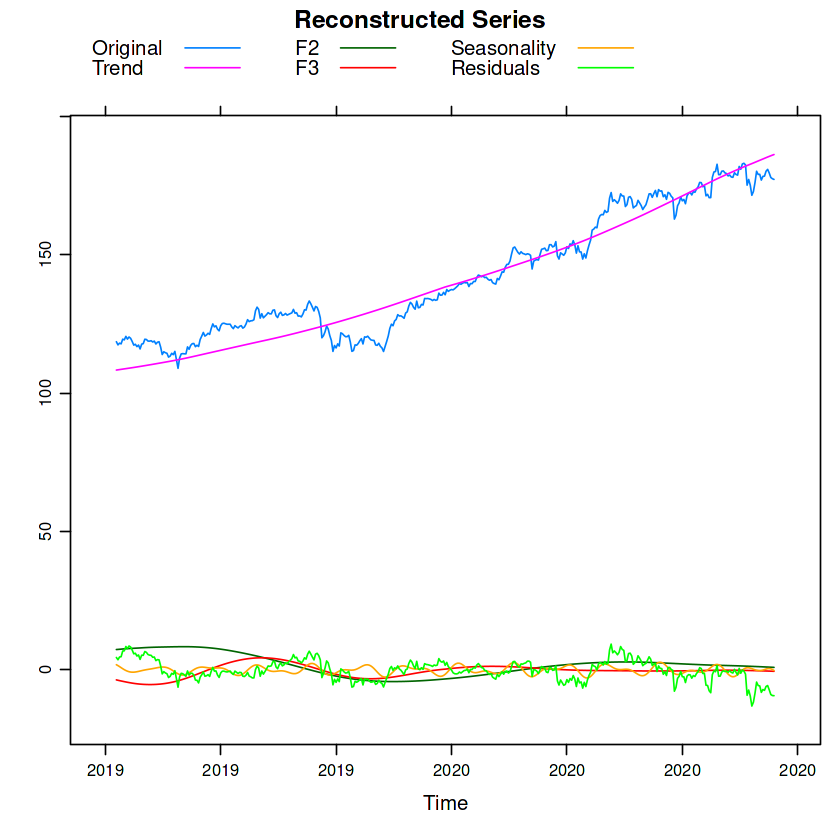

In [60]:
##Fase recontrucción:
r=reconstruct(s1, groups = list(Trend=1,2,3, Seasonality=c(8:9, 10:11)))
plot(r, add.residuals=TRUE, add.original=TRUE, plot.method="xyplot",
     superpose=TRUE, auto.key=list(columns=4))

In [61]:
#Generamos el pronóstico señalando los tripletes de la reconstrucción.
pronostico1<-forecast(s1, groups = list(c(1,2,3,8:11)), len=h, method="recurrent", 
                                   interval = "prediction", level=c(0.8, 0.99),only.new=TRUE )

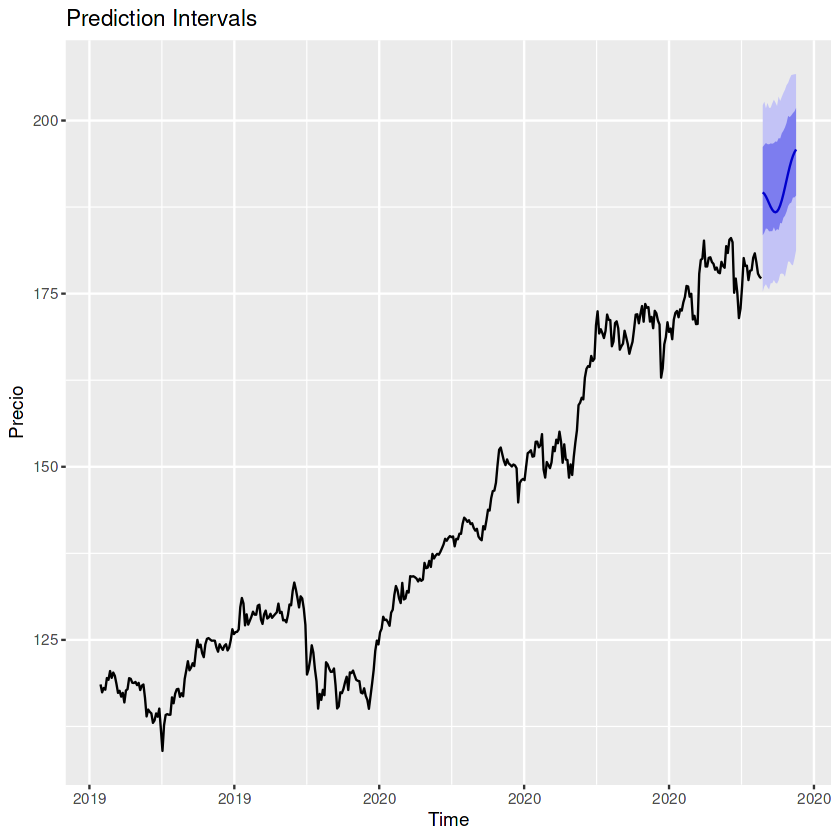

In [56]:
# Graficamos el pronóstico.
autoplot(pronostico1, type="l", main="Prediction Intervals", ylab="Precio")

In [63]:
pred<-pronostico1$mean
pred

A Time Series:
 [1] 188 188 188 187 187 187 187 187 187 188 188 189 190 191 192 193 194 194 195
[20] 195 195 196

In [58]:
###Cálculo error MAPE, RMSE
library(Metrics)
RMSE1<-rmse(test,pred)
RMSE1
MAPE1<-mape(test, pred)
MAPE1
MAE1<-mae(test,pred)
MAE1
MSE1<-mse(test,pred)
MSE1


[1] 8.36

[1] 0.0389

[1] 7.03

[1] 69.8

# Calculo de predicciones a 10 días

In [68]:
s2<-ssa(meta.ts)  #Hay otros métodos como el "topelitz", para series estacionarias. En este caso no aplica.


In [69]:
pronostico2<-forecast(s2, groups = list(c(1,2,3,8:11)), len=10, method="recurrent", 
                                   interval = "prediction", level=c(0.8, 0.99),only.new=TRUE )

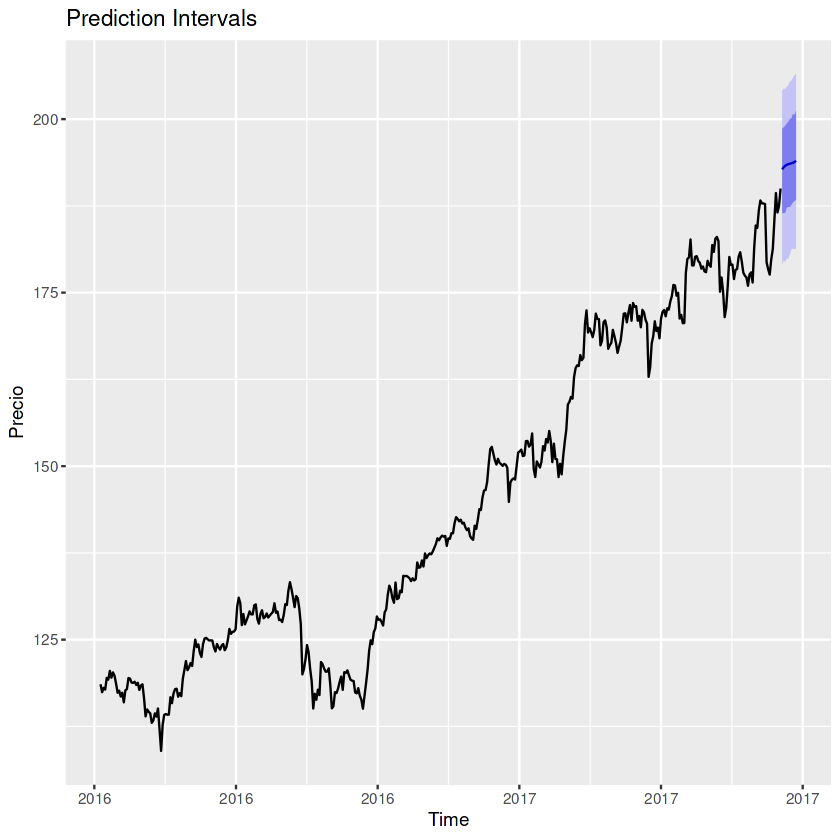

In [71]:
pred2<-pronostico2$mean
# Graficamos el pronóstico.
autoplot(pronostico2, type="l", main="Prediction Intervals", ylab="Precio")